# LPS vs RAS conventions in tractography data

This notebook demonstrates the issues when dealing with LPS vs RAS conventions in tractography files.

We begin downloading the data.

In [21]:
import os
from pathlib import Path

import requests

output_path = Path(os.getcwd())

def download_osf_data(_url, _fname):
    resp = requests.get(_url, allow_redirects=True, stream=True)
    with open(_fname, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

url_osf = ["https://osf.io/tbwm2/download/", "https://osf.io/k2av5/download/"]
t1w_fname = output_path / "t1w.nii.gz"
vtk_fname = output_path / "ukf.vtk"
fnames = [t1w_fname, vtk_fname]

for url, fname in zip(url_osf, fnames, strict=True):
    download_osf_data(url, fname)

Read the T1w and tractography data.

In [22]:
import nibabel as nib
from dipy.io.streamline import load_vtk_streamlines

# Read T1w data
t1_img = nib.load(t1w_fname)
t1_data = t1_img.get_fdata()
affine = t1_img.affine
dims = t1_img.shape

# Read streamline data
streamlines_lps = load_vtk_streamlines(str(vtk_fname))

The tractography data is in LPS. Convert it to RAS.

In [23]:
import numpy as np

# LPS to RAS transformation: flip X and Y axes
lps_to_ras = np.diag([-1, -1, 1])

streamlines_ras = [s @ lps_to_ras for s in streamlines_lps]

Define helper functions to plot the tractograms in the three orthogonal axes overlaid to the T1w data.

In [24]:
import matplotlib.pyplot as plt
from fury import actor, colormap, window

# Compute streamline colors
def compute_streamline_colors(_streamlines):
    local_orientation = [np.diff(list(s), axis=0) for s in _streamlines]
    ext_local_orientation = [[d[0]] + list(d) for d in local_orientation]
    orientations = np.asarray([o for d in ext_local_orientation for o in d])
    color = colormap.orient2rgb(orientations)
    return color

def transform_scene(_view, _scene):
    position = [0, 0, 1]
    focal_point = [0, 0, 0]
    view_up = [0, 1, 0]
    _scene.set_camera(position=position, focal_point=focal_point, view_up=view_up)

    if _view == "axial":
        pass
    elif _view == "coronal":
        _scene.pitch(270)
        _scene.set_camera(view_up=(0, 0, 1))
    elif _view == "sagittal":
        _scene.yaw(-90)
        _scene.roll(90)


def plot_orthogonal_view(_t1_data, _affine, _strml, _views, _slices, _zooms, _background, _size, _figsize, _output_path, _label):
    scene_arr = []
    for _view, _slice, _zoom in zip(_views, _slices, _zooms, strict=True):
        scene = window.Scene()
        scene.background(_background)

        # Add slice actor
        slice_actor = actor.slicer(_t1_data, affine=_affine, value_range=(np.min(_t1_data), np.max(_t1_data)))
        x, y, z = _slice
        slice_actor.display(x=x, y=y, z=z)
        scene.add(slice_actor)

        # Add streamlines
        colors = compute_streamline_colors(_strml)
        stream_actor = actor.line(_strml, colors=colors)
        scene.add(stream_actor)

        # Set camera for consistent view
        transform_scene(_view, scene)
        scene.reset_camera()
        scene.zoom(_zoom)

        # Render and grab image
        _fname = _output_path / Path(_label + _view + ".png")
        arr = window.snapshot(scene, fname=_fname, size=_size, offscreen=True)
        scene_arr.append(arr)

    # Plot all three orthogonal views side by side
    _fig, axes = plt.subplots(1, 3, figsize=_figsize)
    for ax, arr, title in zip(axes, scene_arr, _views, strict=True):
        ax.imshow(arr)
        ax.axis("off")
        ax.set_title(title.capitalize())

    plt.tight_layout()
    return _fig


Plot the result and save it.

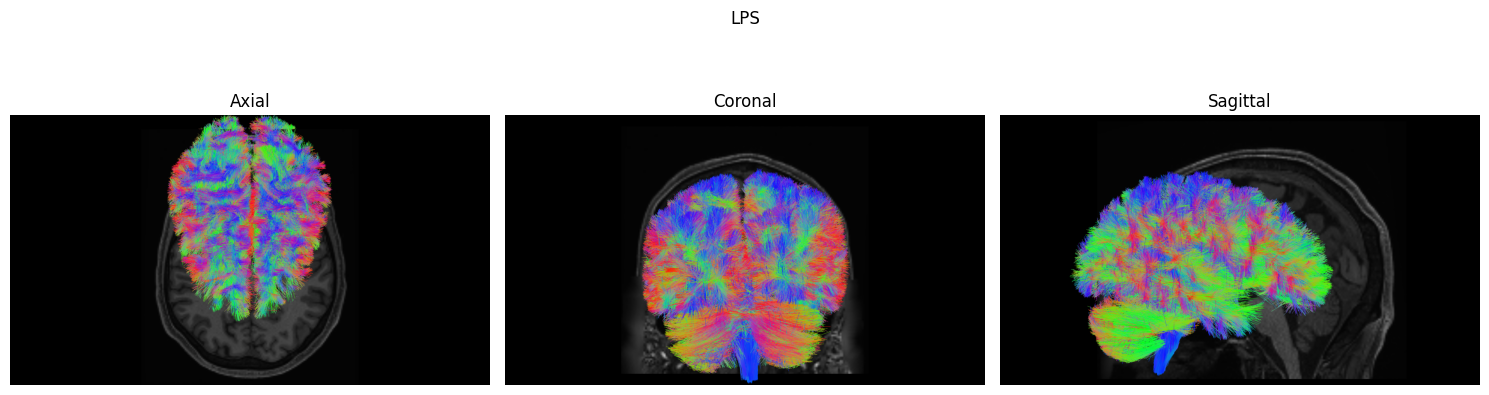

In [ ]:
%matplotlib inline

size = (1920, 1080)
figsize = (15, 5)
background = window.colors.black

streamlines = [streamlines_lps, streamlines_ras]
labels = ["lps_", "ras_"]

views = ["axial", "coronal", "sagittal"]
slices = [
    (None, None, dims[2] // 2),
    (None, dims[1] // 2, None),
    (dims[0] // 2, None, None),
]
zooms_lps_ras = [[1.45, 1.7, 1.75], [1.5, 1.65, 1.75]]

for label, strml, zooms in zip(labels, streamlines, zooms_lps_ras, strict=True):
    fig = plot_orthogonal_view(t1_data, affine, strml, views, slices, zooms, background, size, figsize, output_path, label)
    fig.suptitle(label[:-1].upper())
    plt.show()